Here we test the time step limits for the model problem

$\frac{du}{dt} = \lambda u$

And for RK4 we have:

\begin{equation}
\Delta t < \frac{CFL}{\lambda}
\end{equation}

Where the cfl for RK4 is 2.74.

We have two types of $\lambda$ for our problems. These are the dispersion relations from both damping and oscillation.

Oscillation

The source of the oscilations in our bousinesq model are from the buoyancy due to both temperature and salinity.  For this case 

\begin{equation}
\lambda = \omega_b = \sqrt{\frac{k_z^2 g}{|k|^2}(c_t b_t - c_s b_s)}.
\end{equation}

where the wave numbers are those used in the code as kk and kk_cosine and for the time step limit we take the maximum wave number of the system.

Damping

The source of the time step restriction there will be from the dissipation of any of the equations.

\begin{equation}
\lambda = \max \left(\nu k_N^p, \kappa_t k_N^{p^\prime}, \kappa_s k_N^{p^{\prime\prime}} \right).
\end{equation}


Max velocity

To take care of the CFl from the nonlinear term, the usual practice is to assume it is U_max ik, so that we also test for U_max.

These are tested below.


In [2]:
from numpy import *
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [7]:
def rk4(t, dt, u, params, f_of_u):
    k1 = dt * f_of_u(t, params, u)
    k2 = dt * f_of_u(t + 0.5*dt, params, u + 0.5*k1)
    k3 = dt * f_of_u(t + 0.5*dt, params, u + 0.5*k2)
    k4 = dt * f_of_u(t + dt, params, u + k3)
    return t + dt, u + (k1 + 2.0*(k2 + k3) + k4)/6.0


def ab1(ab1_t, ab1_dt, ab1_u, params, ab1_f_of_u):
    ab1_f_n = ab1_f_of_u(ab1_t, params, ab1_u)
    return ab1_t + ab1_dt, ab1_u + ab1_dt*ab1_f_n, ab1_f_n
def ab2(ab2_t,ab2_dt,ab2_u, params, ab2_f_nm1,ab2_f_of_u):
    ab2_f_n = ab2_f_of_u(ab2_t, params,ab2_u)
    return ab2_t + ab2_dt, ab2_u + ab2_dt*(3./2.*ab2_f_n - 1./2.*ab2_f_nm1), ab2_f_n, ab2_f_nm1
def ab3(ab3_t,ab3_dt,ab3_u, params, ab3_f_nm1,ab3_f_nm2,ab3_f_of_u):
    ab3_f_n = ab3_f_of_u(ab3_t, params, ab3_u)
    return ab3_t + ab3_dt, ab3_u + ab3_dt*(23./12.*ab3_f_n - 16./12.*ab3_f_nm1 + 5./12.*ab3_f_nm2), ab3_f_n, ab3_f_nm1,


def rhs_osc(t, params, u):
    """ 
          This rhs is for linear advection
    """
    a, visc, hyper = params
    u_hat = np.fft.fft(u)
    ux = np.fft.ifft(1j*kk*u_hat)
    return np.array(-a*ux)

def osc_exact(t, params, u0):
    """ The exact solution for linear advection"""
    a, visc, hyper = params
    u0_hat = np.fft.fft(u0)
    return np.array(np.fft.ifft(u0_hat*np.exp(-a*1j*kk*t)))

def visc_exact(t, params, u0):
    """ The exact solution for decay"""
    a, visc, hyper = params
    u0_hat = np.fft.fft(u0)
    if hyper == 2:
        u_exact = np.fft.ifft(u0_hat*np.exp(-visc*kk*kk*t))
    elif hyper == 4:
        u_exact = np.fft.ifft(u0_hat*np.exp(visc*kk*kk*kk*kk*t))
    elif hyper == 6:
        u_exact = np.fft.ifft(u0_hat*np.exp(-visc*kk*kk*kk*kk*kk*kk*t))
    elif hyper == 8:
        u_exact = np.fft.ifft(u0_hat*np.exp(visc*kk*kk*kk*kk*kk*kk*kk*kk*t))
    else:
        print "There is no exact solution for hyper = ", hyper
        quit()
    return np.array(u_exact)

def rhs_decay(t, params, u):
    """ 
          This rhs is for an testing
    """
    a, visc, hyper = params
    u_hat = np.fft.fft(u)
    if hyper == 2:
        uxder = np.fft.ifft(-kk*kk*u_hat)
    elif hyper == 4:
        uxder = np.fft.ifft(kk*kk*kk*kk*u_hat)
    elif hyper == 6:
        uxder = np.fft.ifft(-kk*kk*kk*kk*kk*kk*u_hat)
    elif hyper == 8:
        uxder = np.fft.ifft(kk*kk*kk*kk*kk*kk*kk*kk*u_hat)
    else:
        print "There is no rhs_decay for hyper = ", hyper
        raise
    return np.array(visc*uxder)

def TimeControl(t, params, u, x_grid, kk, scheme):
    """ This function outputs the maximum time step for the frequency and decay rate """
    a, visc, hyper = params
    
    if scheme == 'rk4':
        C_visc = 2.74 # Conservative for the real axis (dissipation)
        C_osc = 2.80 # Also conservative
    elif scheme == 'ab1':
        C_visc = 1.0
        C_osc = 1.0 # Unconditionally unstable for oscillations! There's a 1 here just to have a value.
    elif scheme == 'ab3':
        C_visc = .53
        C_osc = .71
    else:
        print "No time stepping scheme specified"
        raise
        
    max_kk = max(np.abs(kk))
    osc_max = max(a,max(u.real))*max_kk  # This is for first derivative terms
    dt_osc = C_osc/osc_max
    
    abs_visc = np.abs(visc) # This is for future dealiasing
    
    if hyper == 2:
        visc_max = abs_visc*max_kk**2    # For 2nd derivative damping  The 3s are for deaialising
    elif hyper == 4:
        visc_max = abs_visc*max_kk**4
    elif hyper == 6:
        visc_max = abs_visc*max_kk**6
    elif hyper == 8:
        visc_max = abs_visc*max_kk**8
    else:
        print "No hyper viscosity of order", hyper
        raise

    dt_visc = C_visc/visc_max
    
    # Check to see if either oscillations or decay are turned off. If so, don't test for them.
    #
    # For example, if it is only decay and you are testing for the osc CFL, the dt will decrease
    # with the decreasing amplitude! And you will never finish the calculation!
    #
    
    if np.abs(a) < 1.e-8:
        #  This is a decay problem only
        dt_max = dt_visc
    elif np.abs(visc) == 0.:
        # This is an oscillation problem only
        dt_max = dt_osc
    else:
        # This has both components of the problem
        dt_max = min(dt_osc, dt_visc)
    
    if dt_max < 1.e-5:
        print "Warning, dt max is too small for the calculation. Quitting.", dt_max
        raise
        
    #print "dt = ",dt_max, dt_osc, dt_visc
    return dt_max

In [8]:
Lx = 2.*np.pi
Nx = 64
delta_x = Lx/(float(Nx) - 1.) 
x_grid = np.arange(Nx)*delta_x
u = np.zeros(Nx, dtype=complex128)
kk = np.fft.fftfreq(Nx,Lx/Nx)*2.*np.pi
print kk

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20.
 -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.
  -4.  -3.  -2.  -1.]


In [15]:

#
# Set the initial conditions
#

t = 0.
u.real = 1. - cos(4*x_grid)
u0 = np.copy(u)             # This is so we can keep track of the initial condition

#
# Set the physical parameters
#


EndTime = 5.
a       = 0.  # .2  # When zero this is viscous only
visc    = 0.1 # This is just a starting value

scheme = 'rk4'
hyper = 8
if hyper == 2 or hyper == 6:
    visc = visc/max(kk)**np.int(hyper-2)  # This selects a sensible value for the viscosity
elif hyper == 4 or hyper == 8:
    visc = -visc/max(kk)**np.int(hyper-2)
print "visc =", visc, "hyper = ", hyper

params = np.array([a, visc, hyper])

dt = 1./400.
N_plot = 5

Ntotal_time = np.int(EndTime/dt)+1
PlotInterval = EndTime/N_plot

print Ntotal_time, PlotInterval

plot_array   = np.zeros((N_plot+1,Nx)) # Declare array for plotting
exact_array  = np.zeros((N_plot+1,Nx)) # Declare array for plotting
time_array   = np.zeros((N_plot+1))    # Declare array to hold the time steps
error_array  = np.zeros((N_plot+1))    # Declare array to hold the time steps

t = 0
time_array[0]    = t                       # Set the initial time
plot_array[0,:]  = u.real                       # Set the initial condition
exact_array[0,:] = visc_exact(t, params, u).real
error_array[0]   = np.abs(max(plot_array[0,:]-exact_array[0,:]))

i_iterations = 0
i_plots = 0
PlotTime = 0


dt = TimeControl(0, params, u, x_grid, kk, scheme)
print "First guess for dt", dt

if dt < 1e-4:
    print "dt too small", dt
    print "Ending execution"
    raise


while t < EndTime:
    dt = TimeControl(t, params, u, x_grid, kk, scheme)
    if dt < 1e-4:
        print "dt too small", dt
        print "Ending execution"
        raise
#    print "New guess for dt in loop", dt
#    t, u, fn = ab1(t, dt, u, params, burgers)
    t, u = rk4(t, dt, u, params, rhs_decay)
    if np.abs(t - PlotTime) < dt+1.e-5:
        time_array[i_plots]    = t
        plot_array[i_plots,:]  = np.real(u)
        exact_array[i_plots,:] = visc_exact(t, params, u0).real
        error_array[i_plots]   = np.abs(max(plot_array[0,:]-exact_array[0,:]))
        i_plots +=1
        PlotTime += PlotInterval
        print('%10f %10f' % (t,u[0].real))
    i_iterations += 1
    
    


visc = -1.12675589004e-10 hyper =  8
2001 1.0
First guess for dt 0.0221167291415
  0.022117  -0.000548
  0.995253  -0.005977
  1.990506  -0.007993
  2.985758  -0.009356
  3.981011  -0.010411
  4.998381  -0.011298


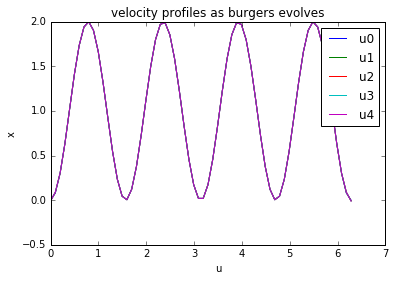

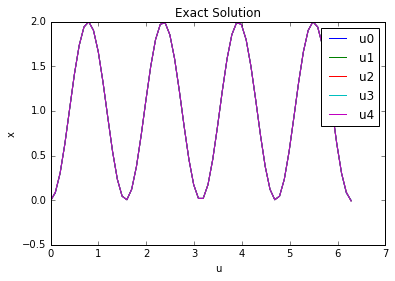

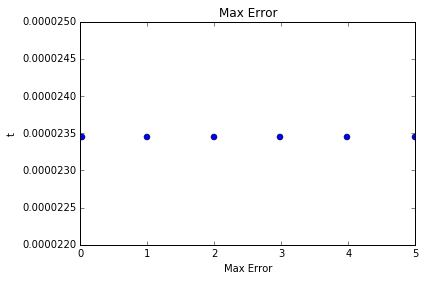

In [16]:
fig_burgers = plt.figure(2)
fig,ax = plt.subplots()
p1, = plt.plot(x_grid,plot_array[0,:],)
p2, = plt.plot(x_grid,plot_array[1,:])
p3, = plt.plot(x_grid,plot_array[2,:])
p4, = plt.plot(x_grid,plot_array[3,:])
p5, = plt.plot(x_grid,plot_array[4,:])
plt.legend([p1, p2, p3, p4, p5],["u0", "u1", "u2", "u3", "u4"])
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('velocity profiles as burgers evolves')
plt.xlabel('u')
plt.ylabel('x')

plt.show(3)
fig_burgers_exact = plt.figure(3)
fig,ax = plt.subplots()
p1, = plt.plot(x_grid,exact_array[0,:])
p2, = plt.plot(x_grid,exact_array[1,:])
p3, = plt.plot(x_grid,exact_array[2,:])
p4, = plt.plot(x_grid,exact_array[3,:])
p5, = plt.plot(x_grid,exact_array[4,:])
plt.legend([p1, p2, p3, p4, p5],["u0", "u1", "u2", "u3", "u4"])
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Exact Solution')
plt.xlabel('u')
plt.ylabel('x')
plt.show(3)


fig_burgers_exact = plt.figure(4)
fig,ax = plt.subplots()
plt.plot(time_array,error_array[:], 'bo')
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Max Error')
plt.xlabel('Max Error')
plt.ylabel('t')
plt.show(4)



In [1]:
print plot_array[2,:]

NameError: name 'plot_array' is not defined